In [1]:
import pandas_profiling
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from geopandas import GeoSeries
from pyproj import Proj, transform
from descartes import PolygonPatch
%matplotlib inline

In [52]:
time_subset = '2015-11-23 18:00:00'
data_type = 'veg'

LAT_START = 31.52
LON_START = -125.48
LAT_END = 43.0
LON_END = -113.131
GRID_SPACING = 0.1

num_contour_levels = 50
weather_datafile = '../data/NOAA_weather_data/2015_california_box_all.csv'
weather_datafile_ca_only = '../data/NOAA_weather_data/2015_california_only_all.csv'
states_shapefile = '../data/spatial_data/cb_2018_us_state_500k.shp'

In [47]:
def regularize_grid(data, data_type):
    #data = data.dropna()
    
    # data coordinates and values
    x = data['lon']
    y = data['lat']
    z = data[data_type]

    # target grid to interpolate to
    xi = np.arange(LON_START,LON_END,GRID_SPACING)
    yi = np.arange(LAT_START,LAT_END,GRID_SPACING)
    xi,yi = np.meshgrid(xi,yi)

    # interpolate
    zi = griddata((x,y),z,(xi,yi),method='cubic')
    
    return xi, yi, zi

def get_california_polygon(shapefile):
    gdf = gpd.read_file(shapefile)
    california = gdf[gdf['NAME'] == 'California']
    return(california)

def convert_map_projection(xi, yi):
    inProj = Proj(init='epsg:4326')
    outProj = Proj(init='epsg:3857')
    x2, y2 = transform(inProj, outProj, xi, yi)
    return(x2, y2)

In [40]:
data = pd.read_csv(weather_datafile)
data_california_only = pd.read_csv(weather_datafile_ca_only)
data_one_hour = data[data['time'] == time_subset]
data_one_hour = data_one_hour.fillna(0)

In [53]:
xi, yi, zi = regularize_grid(data_one_hour, data_type)
california = get_california_polygon(states_shapefile)

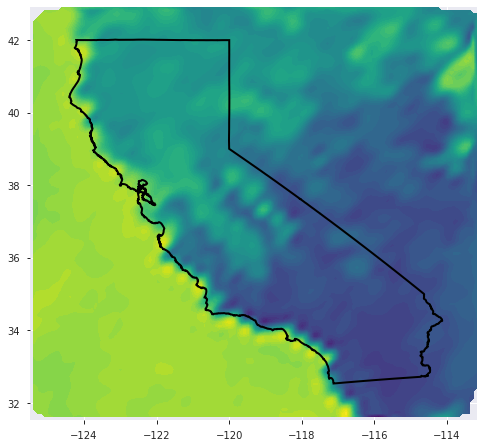

In [49]:
multipoly = california.loc[16, 'geometry']
california_land_mass = multipoly[-1]

plt.rcParams["figure.figsize"] = (8,8)
fig = plt.figure() 
ax = fig.gca() 
ax.add_patch(PolygonPatch(california_land_mass, fc='none', ec='black', lw='2', zorder=2))
ax.contourf(xi, yi, zi, num_contour_levels, cmap='viridis')
ax.axis('scaled')
plt.show()

<Figure size 576x576 with 0 Axes>

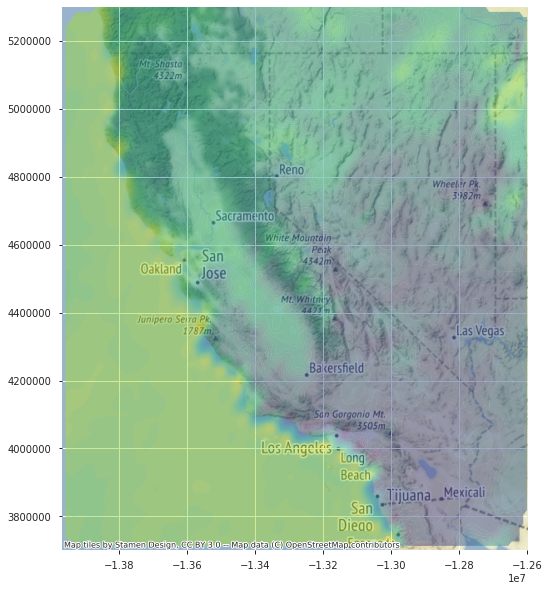

In [50]:
x2, y2 = convert_map_projection(xi, yi)
california_3857 = california.to_crs(epsg=3857)

plt.rcParams["figure.figsize"] = (8,8)
fig = plt.figure() 
ax = california_3857.plot(figsize=(10, 10), alpha=0.0, edgecolor='k')
ax.contourf(x2, y2, zi, num_contour_levels, alpha=0.5, antialiased=True, cmap='viridis')
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=6)
plt.show()

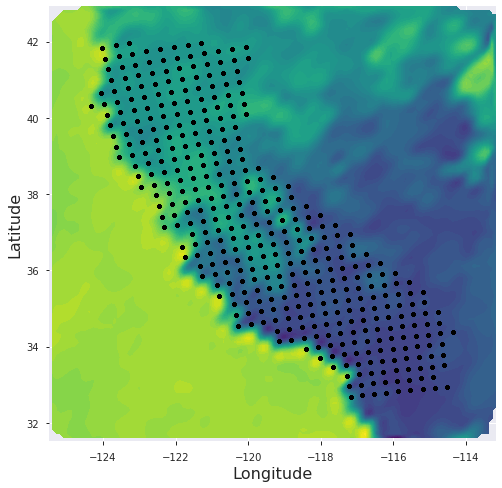

In [51]:
x = data_california_only['lon']
y = data_california_only['lat']

plt.rcParams["figure.figsize"] = (8,8)
plt.contourf(xi, yi, zi, num_contour_levels, cmap='viridis')
plt.plot(x, y, 'k.')
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.show()

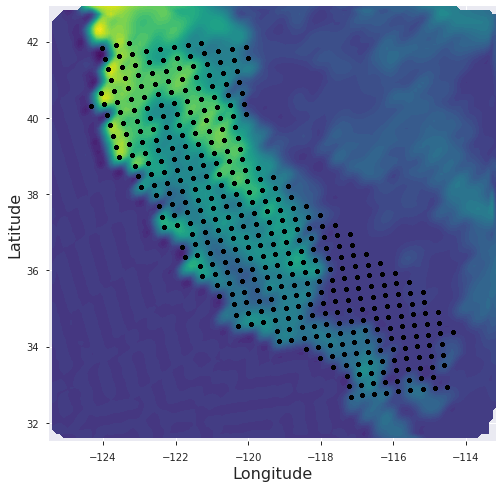

In [54]:
x = data_california_only['lon']
y = data_california_only['lat']

plt.rcParams["figure.figsize"] = (8,8)
plt.contourf(xi, yi, zi, num_contour_levels, cmap='viridis')
plt.plot(x, y, 'k.')
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.show()